In [1]:

import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install torchvision

In [3]:
!pip install torch

## Q2 - 1 -Computing Target (Xij) dataset from movielens

### Loading Datasets

In [4]:


ratings_ds = pd.read_csv('C:/Users/ritig/Downloads/archive (2)/ratings.csv')
movies_ds = pd.read_csv('C:/Users/ritig/Downloads/archive (2)/movies.csv')
tags_ds = pd.read_csv('C:/Users/ritig/Downloads/archive (2)/tags.csv')
links_ds=  pd.read_csv('C:/Users/ritig/Downloads/archive (2)/links.csv')

In [5]:
#adding column to ratings table to check whether user likes a movie or not

ratings_ds['Like']=np.where(ratings_ds['rating']>=4,1,0)

In [6]:
ratings_ds2 = ratings_ds.drop(['rating'],axis=1) #Dropping rating column

In [7]:


ratings_ds2_pivot = ratings_ds2.pivot(index = 'userId', columns ='movieId', values = 'Like').fillna(0)

In [8]:
ratings_ds2_pivot.shape

(610, 9724)

In [9]:

rating_co_occ = ratings_ds2_pivot.T.dot(ratings_ds2_pivot)

In [10]:
rating_co_occ.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,147.0,21.0,11.0,0.0,7.0,27.0,7.0,1.0,4.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,50.0,5.0,0.0,4.0,8.0,6.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,5.0,18.0,0.0,4.0,4.0,5.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7.0,4.0,4.0,0.0,12.0,3.0,4.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
rating_co_occ.shape

(9724, 9724)

##  Creating and optimising the loss function

In [12]:

observed=rating_co_occ.to_numpy()
np.fill_diagonal(observed, 0)

In [13]:

observed = torch.from_numpy(rating_co_occ.to_numpy()).float()
observed

tensor([[ 0., 21., 11.,  ...,  0.,  0.,  0.],
        [21.,  0.,  5.,  ...,  0.,  0.,  0.],
        [11.,  5.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [14]:

reference = rating_co_occ.reset_index()
reference = reference.merge(movies_ds, on='movieId', how='inner')

In [15]:
reference["movie"]=reference["title"].str.split('(',expand=True)[0].str.strip().str.lower()

In [16]:
reference.head(3)

,movieId,1,2,3,4,5,6,7,8,9,...,193573,193579,193581,193583,193585,193587,193609,title,genres,movie
0,1,0.0,21.0,11.0,0.0,7.0,27.0,7.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toy story
1,2,21.0,0.0,5.0,0.0,4.0,8.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jumanji (1995),Adventure|Children|Fantasy,jumanji
2,3,11.0,5.0,0.0,0.0,4.0,4.0,5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grumpier Old Men (1995),Comedy|Romance,grumpier old men


In [17]:


from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = reference["movieId"].unique()
values = array(data)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

[     1      2      3 ... 193585 193587 193609]
[   0    1    2 ... 9721 9722 9723]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[1]


In [18]:


movies_tensor = torch.from_numpy(onehot_encoded).float()
movies_tensor= torch.tensor(movies_tensor)


In [19]:

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
        optimizer.zero_grad()

  
    loss.backward()

  
    optimizer.step()





0 63482972.0
20 22642630.0
40 8412664.0
60 5158022.0
80 3708338.25
100 2761467.0
120 2102099.0
140 1635955.5
160 1300654.875
180 1053054.5
200 866583.4375


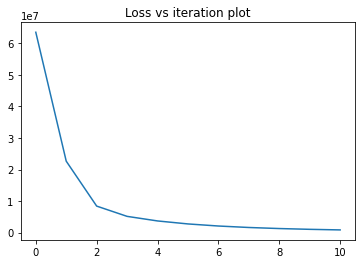

In [20]:

import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

In [21]:


def prediction(moviename):
    
   
    moviename= moviename.lower()
    idx = reference[reference["movie"]== moviename].index[0]   
    movie = movies_tensor[idx]
    movie = movie.reshape(1,movie.shape[0])
    
   
    for name, param in model.named_parameters():
        weight_vector = param
    
    
    movie_i = model(movie)
    pred = torch.mm(movie_i,weight_vector)
    
    
    pred_idx = (-np.asanyarray(pred[0].detach().numpy())).argsort()[:10]
    
    recommendations = reference["title"].iloc[pred_idx]
    
    return recommendations
    

In [22]:

def observed_reco(moviename):
    
    
    idx = reference[reference["movie"]== moviename].index[0]
    
    
    obs_idx = (-np.asanyarray(rating_co_occ.iloc[idx])).argsort()[:10]
    
    
    recommendations = reference["title"].iloc[obs_idx]
    
    return recommendations

In [23]:
display("Model Predictions:",prediction("APOLLO 13"),"Actual Predictions:", observed_reco("apollo 13"))

'Model Predictions:'

314                          Forrest Gump (1994)
277             Shawshank Redemption, The (1994)
257                          Pulp Fiction (1994)
510             Silence of the Lambs, The (1991)
123                             Apollo 13 (1995)
97                             Braveheart (1995)
418                         Jurassic Park (1993)
398                         Fugitive, The (1993)
461                      Schindler's List (1993)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

'Actual Predictions:'

277             Shawshank Redemption, The (1994)
314                          Forrest Gump (1994)
257                          Pulp Fiction (1994)
418                         Jurassic Park (1993)
510             Silence of the Lambs, The (1991)
398                         Fugitive, The (1993)
97                             Braveheart (1995)
461                      Schindler's List (1993)
507            Terminator 2: Judgment Day (1991)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

In [24]:
display("Model Predictions:",prediction("toy story"),"Actual Predictions:", observed_reco("toy story"))

'Model Predictions:'

314                                   Forrest Gump (1994)
277                      Shawshank Redemption, The (1994)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
224             Star Wars: Episode IV - A New Hope (1977)
1938                                   Matrix, The (1999)
897     Star Wars: Episode V - The Empire Strikes Back...
899     Raiders of the Lost Ark (Indiana Jones and the...
0                                        Toy Story (1995)
418                                  Jurassic Park (1993)
Name: title, dtype: object

'Actual Predictions:'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
897     Star Wars: Episode V - The Empire Strikes Back...
1938                                   Matrix, The (1999)
418                                  Jurassic Park (1993)
899     Raiders of the Lost Ark (Indiana Jones and the...
910     Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object

In [25]:
display("Model Predictions:",prediction("home alone"),"Actual Predictions:", observed_reco("home alone"))

'Model Predictions:'

314                                   Forrest Gump (1994)
504                                     Home Alone (1990)
418                                  Jurassic Park (1993)
277                      Shawshank Redemption, The (1994)
506                                        Aladdin (1992)
322                                 Lion King, The (1994)
1938                                   Matrix, The (1999)
224             Star Wars: Episode IV - A New Hope (1977)
0                                        Toy Story (1995)
897     Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object

'Actual Predictions:'

314                   Forrest Gump (1994)
418                  Jurassic Park (1993)
277      Shawshank Redemption, The (1994)
506                        Aladdin (1992)
322                 Lion King, The (1994)
507     Terminator 2: Judgment Day (1991)
0                        Toy Story (1995)
510      Silence of the Lambs, The (1991)
1938                   Matrix, The (1999)
257                   Pulp Fiction (1994)
Name: title, dtype: object

In [26]:

import torch
torch.nn.Linear

D_in,H, D_out = 9724, 300, 9724
loss_array =[]

x = movies_tensor
y = observed


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    optimizer.zero_grad()

    
    loss.backward()

   
    optimizer.step()




0 63482972.0
20 7934567424.0
40 701364544.0
60 69960000.0
80 17017092.0
100 9542524.0
120 7088697.5
140 5666078.0
160 4703708.0
180 4000393.75
200 3460939.0


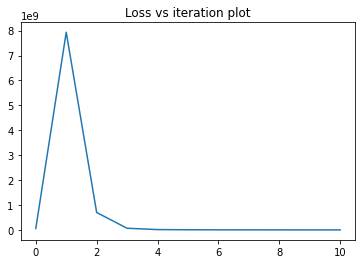

In [27]:

import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

In [28]:
prediction("apollo 13")

277     Shawshank Redemption, The (1994)
314                  Forrest Gump (1994)
257                  Pulp Fiction (1994)
510     Silence of the Lambs, The (1991)
97                     Braveheart (1995)
418                 Jurassic Park (1993)
398                 Fugitive, The (1993)
123                     Apollo 13 (1995)
461              Schindler's List (1993)
507    Terminator 2: Judgment Day (1991)
Name: title, dtype: object

#### Lowering the learning rate by 100 times to 0.0001

In [29]:
import torch
torch.nn.Linear

D_in,H, D_out = 9724, 300, 9724
loss_array =[]

x = movies_tensor
y = observed


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

   
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()




0 63482980.0
20 63455836.0
40 63349880.0
60 63132460.0
80 62796696.0
100 62353268.0
120 61818904.0
140 61210540.0
160 60543556.0
180 59830428.0
200 59080836.0


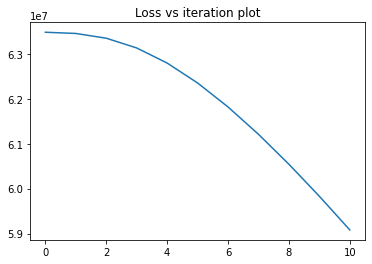

In [30]:
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

#### The predictions for Apollo 13 will show that these are much different than the actual predictions and also from the one we have recommended when the learning rate is 0.01

In [31]:
prediction("apollo 13")

989     Indiana Jones and the Last Crusade (1989)
123                              Apollo 13 (1995)
599        Wallace & Gromit: A Close Shave (1995)
277              Shawshank Redemption, The (1994)
224     Star Wars: Episode IV - A New Hope (1977)
1297                     Big Lebowski, The (1998)
659                         Godfather, The (1972)
1266                      Truman Show, The (1998)
2637                       American Psycho (2000)
2353                           Toy Story 2 (1999)
Name: title, dtype: object

### Our Analysis

#### Learning rate scales the magnitude of our weights in order to minimize the network's loss function. If learning rate is set to a high value it would keep bouncing as it nears the optimal point and my not reach the optimal point and thus give us incorrect recommendations. Whereas, if learning rate is too small, then training will progress very slowly as we are making very tiny updates to the weight and there is a chance to get stuck in local minima and our gradient descent function will give constant loss with increase in iterations, resulting in high cost and incorrect recommendations.